In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

2023-05-18 12:53:02.363518: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


https://machinelearningmastery.com/building-transformer-models-with-attention-crash-course-build-a-neural-machine-translator-in-12-days/

In [2]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.9.0
keras.api._v2.keras 2.9.0


In [3]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print( len(gpus) )

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1


In [5]:
import pathlib

# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
# show where the file is located now
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)

/home/mike/.keras/datasets/fra.txt


In [6]:
import pathlib
import pickle
import random
import re
import unicodedata

import tensorflow as tf

# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
text_file = pathlib.Path(text_file).parent / "fra.txt"

def normalize(line):
    """Normalize a line of text and split into two at the tab character"""
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra

# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)

("why don't you help us ?", '[start] pourquoi ne nous aidez-vous pas  ?  [end]')
('it was a dangerous journey .', "[start] c'était un voyage dangereux . [end]")
("that's just what he needed .", "[start] c'est précisément ce qu'il lui fallait . [end]")
('you should spend what little time you have left with your friends .', "[start] vous devriez passer les moindres moments qu'il vous reste avec vos amis . [end]")
("i've got something better .", "[start] j'ai quelque chose de meilleur . [end]")


In [7]:
import pickle

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


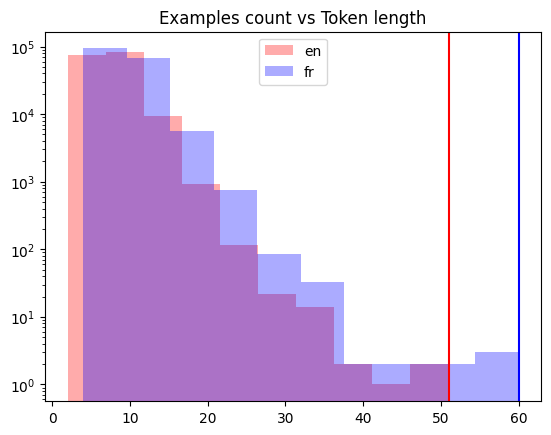

In [8]:
import pickle

import matplotlib.pyplot as plt

with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]

plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()

In [9]:
import pickle
import random

from tensorflow.keras.layers import TextVectorization

# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

# Parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20

# Create vectorizer
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)

# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

2023-05-18 12:53:17.035139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 12:53:18.620339: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


In [10]:
import pickle

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used

eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

# set up Dataset object
def format_dataset(eng, fra):
    """Take an English and a French sentence pair, convert into input and target.
    The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
    is a vector, corresponding to English and French sentences respectively.
    The target is also vector of the French sentence, advanced by 1 token. All
    vector are in the same length.

    The output will be used for training the transformer model. In the model we
    will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
    which should be matched to the keys in the dictionary for the source part
    """
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    """Create TensorFlow Dataset for the sentence pairs"""
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [  50  218    5  209   69   37   39 1220 6522    2    0    0    0    0
    0    0    0    0    0    0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [   2   15   18  249    6   46  873   48  994    6  131 2745 7760    4
    3    0    0    0    0    0]
targets.shape: (64, 20)
targets[0]: [  15   18  249    6   46  873   48  994    6  131 2745 7760    4    3
    0    0    0    0    0    0]


2023-05-18 12:53:31.572918: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


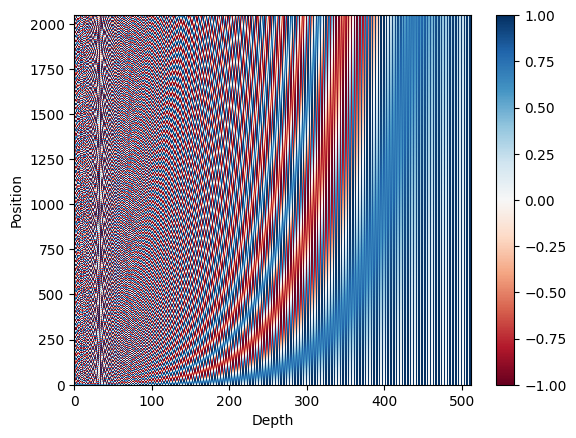

In [11]:
import pickle

import matplotlib.pyplot as plt
import numpy as np


def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P


# Plot the positional encoding matrix
pos_matrix = pos_enc_matrix(L=2048, d=512)
assert pos_matrix.shape == (2048, 512)
plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

with open("posenc-2048-512.pickle", "wb") as fp:
    pickle.dump(pos_matrix, fp)

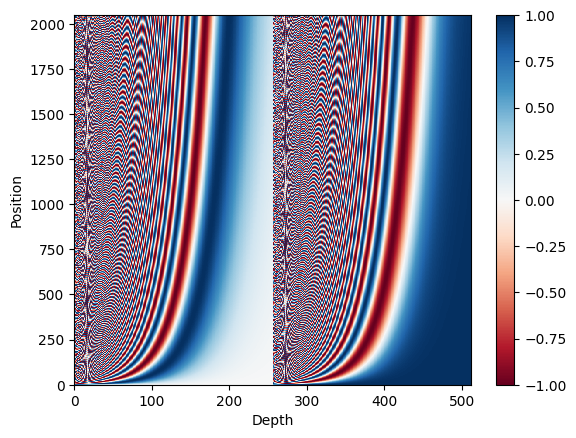

In [12]:
import pickle

import matplotlib.pyplot as plt
import numpy as np


with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot the positional encoding matrix, alternative way
plt.pcolormesh(np.hstack([pos_matrix[:, ::2], pos_matrix[:, 1::2]]), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()


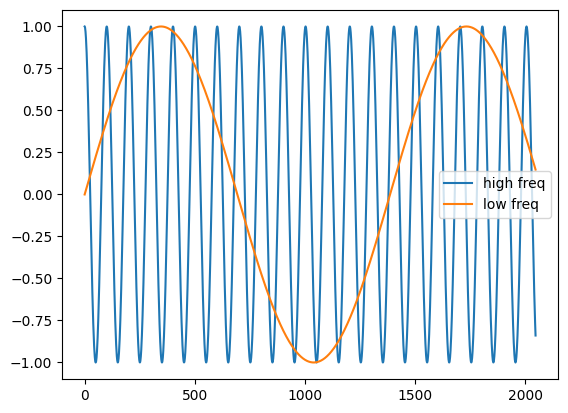

In [13]:
...
plt.plot(pos_matrix[:, 155], label="high freq")
plt.plot(pos_matrix[:, 300], label="low freq")
plt.legend()
plt.show()

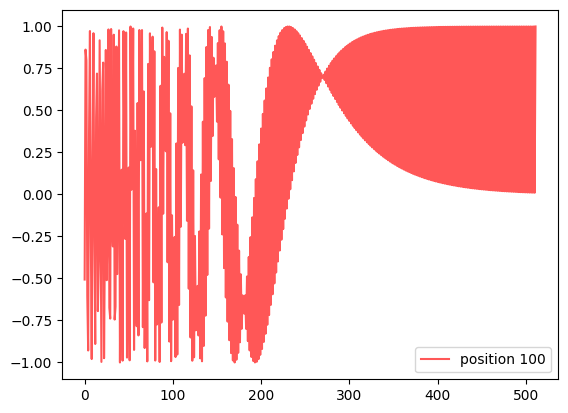

In [14]:
import pickle
import matplotlib.pyplot as plt

with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Plot two curves from different position
plt.plot(pos_matrix[100], alpha=0.66, color="red", label="position 100")
plt.legend()
plt.show()

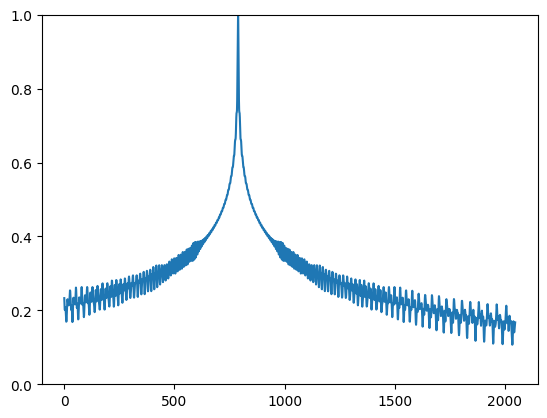

In [15]:
import pickle

import matplotlib.pyplot as plt
import numpy as np


with open("posenc-2048-512.pickle", "rb") as fp:
    pos_matrix = pickle.load(fp)
assert pos_matrix.shape == (2048, 512)
# Show the dot product between different normalized positional vectors
pos_matrix /= np.linalg.norm(pos_matrix, axis=1, keepdims=True)
p = pos_matrix[789]  # all vectors compare to vector at position 789
dots = pos_matrix @ p
plt.plot(dots)
plt.ylim([0, 1])
plt.show()

In [16]:
import numpy as np
import tensorflow as tf

def pos_enc_matrix(L, d, n=10000):
    """Create positional encoding matrix

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d//2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)     # L-column vector
    i = np.arange(d2).reshape(1, -1)    # d-row vector
    denom = np.power(n, -i/d2)          # n**(-2*i/d)
    args = k * denom                    # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

class PositionalEmbedding(tf.keras.layers.Layer):
    """Positional embedding layer. Assume tokenized input, transform into
    embedding and returns positional-encoded output."""
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Args:
            sequence_length: Input sequence length
            vocab_size: Input vocab size, for setting up embedding matrix
            embed_dim: Embedding vector size, for setting up embedding matrix
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim     # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(sequence_length, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype="float32")

    def call(self, inputs):
        """Input tokens convert into embedding vectors then superimposed
        with position vectors"""
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    # this layer is using an Embedding layer, which can take a mask
    # see https://www.tensorflow.org/guide/keras/masking_and_padding#passing_mask_tensors_directly_to_layers
    def compute_mask(self, *args, **kwargs):
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

In [17]:
# From Lesson 03:
# train_ds = make_dataset(train_pairs)

vocab_size_en = 10000
seq_length = 20

# test the dataset
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)

tf.Tensor(
[[ 44 157  15 ...   0   0   0]
 [100  41   6 ...   0   0   0]
 [ 29  61 100 ...   0   0   0]
 ...
 [226  32 174 ...   0   0   0]
 [ 15   9  32 ...   0   0   0]
 [  3  31  71 ...   0   0   0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


2023-05-18 12:53:33.644373: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


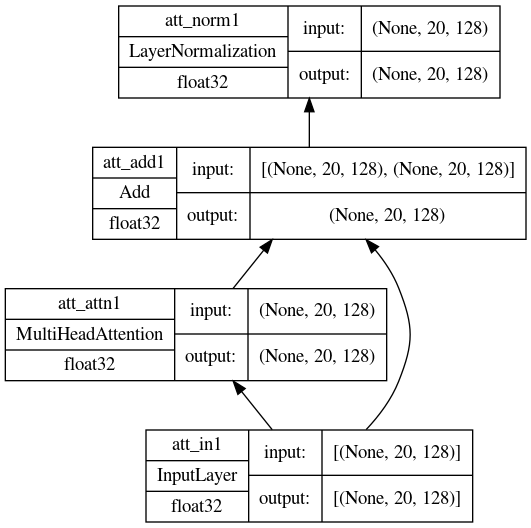

In [18]:
import tensorflow as tf

def self_attention(input_shape, prefix="att", **kwargs):
    """Self-attention layers at transformer encoder and decoder. Assumes its
    input is the output from positional encoding layer.

    Args:
        prefix (str): The prefix added to the layer names
        masked (bool): whether to use causal mask. Should be False on encoder and
                       True on decoder. When True, a mask will be applied such that
                       each location only has access to the locations before it.
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")
    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs)
    outputs = norm(add([inputs, attout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

seq_length = 20
key_dim = 128
num_heads = 8

model = self_attention(input_shape=(seq_length, key_dim),
                       num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "self-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

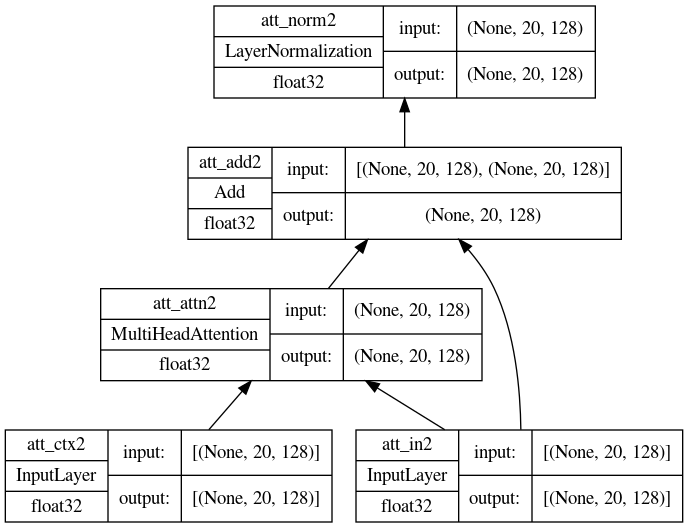

In [19]:
import tensorflow as tf

def cross_attention(input_shape, context_shape, prefix="att", **kwargs):
    """Cross-attention layers at transformer decoder. Assumes its
    input is the output from positional encoding layer at decoder
    and context is the final output from encoder.

    Args:
        prefix (str): The prefix added to the layer names
    """
    # create layers
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32',
                                    name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
    add = tf.keras.layers.Add(name=f"{prefix}_add2")
    # functional API to connect input to output
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))
    # create model and return
    model = tf.keras.Model(inputs=[(context, inputs)], outputs=outputs,
                           name=f"{prefix}_cross")
    return model

seq_length = 20
key_dim = 128
num_heads = 8

model = cross_attention(input_shape=(seq_length, key_dim),
                        context_shape=(seq_length, key_dim),
                        num_heads=num_heads, key_dim=key_dim)
tf.keras.utils.plot_model(model, "cross-attention.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

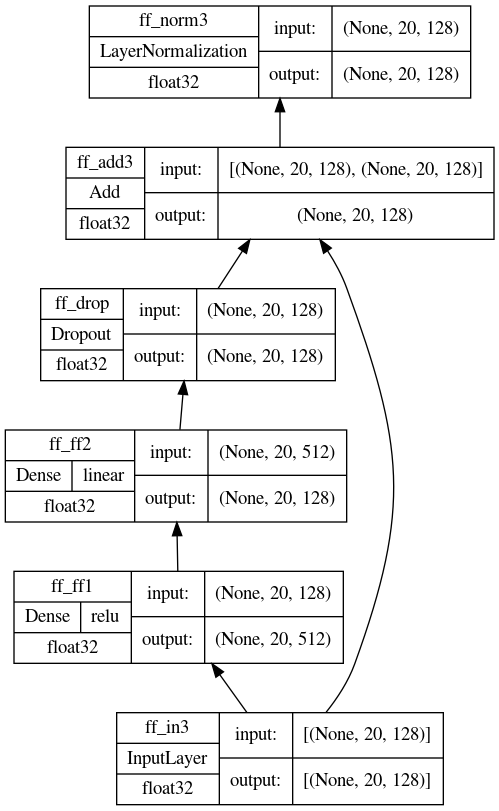

In [20]:
import tensorflow as tf

def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
    """Feed-forward layers at transformer encoder and decoder. Assumes its
    input is the output from an attention layer with add & norm, the output
    is the output of one encoder or decoder block

    Args:
        model_dim (int): Output dimension of the feed-forward layer, which
                         is also the output dimension of the encoder/decoder
                         block
        ff_dim (int): Internal dimension of the feed-forward layer
        dropout (float): Dropout rate
        prefix (str): The prefix added to the layer names
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    # functional API to connect input to output
    ffout = drop(dense2(dense1(inputs)))
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")
    outputs = norm(add([inputs, ffout]))
    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

seq_length = 20
key_dim = 128
ff_dim = 512

model = feed_forward(input_shape=(seq_length, key_dim),
                     model_dim=key_dim, ff_dim=ff_dim)
tf.keras.utils.plot_model(model, "feedforward.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

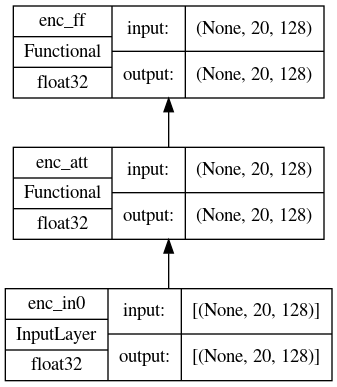

In [21]:
import tensorflow as tf

def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """One encoder unit. The input and output are in the same shape so we can
    daisy chain multiple encoder units into one larger encoder"""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = encoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "encoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

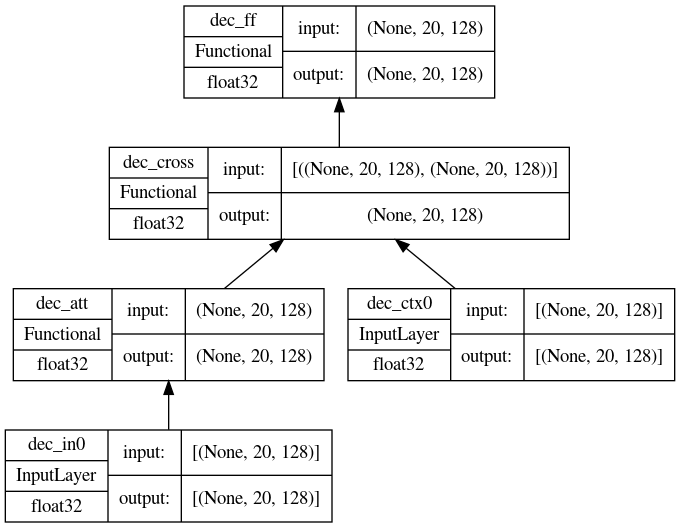

In [22]:
import tensorflow as tf

def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience"""
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                   name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32',
                                    name=f"{prefix}_ctx0")
    attmodel = self_attention(input_shape, key_dim=key_dim, prefix=prefix, **kwargs)
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim,
                                 prefix=prefix, **kwargs)
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)
    x = attmodel(inputs)
    x = crossmodel([(context, x)])
    output = ffmodel(x)
    model = tf.keras.Model(inputs=[(inputs, context)], outputs=output, name=prefix)
    return model


seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

model = decoder(input_shape=(seq_length, key_dim), key_dim=key_dim, ff_dim=ff_dim,
                num_heads=num_heads)
tf.keras.utils.plot_model(model, "decoder.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

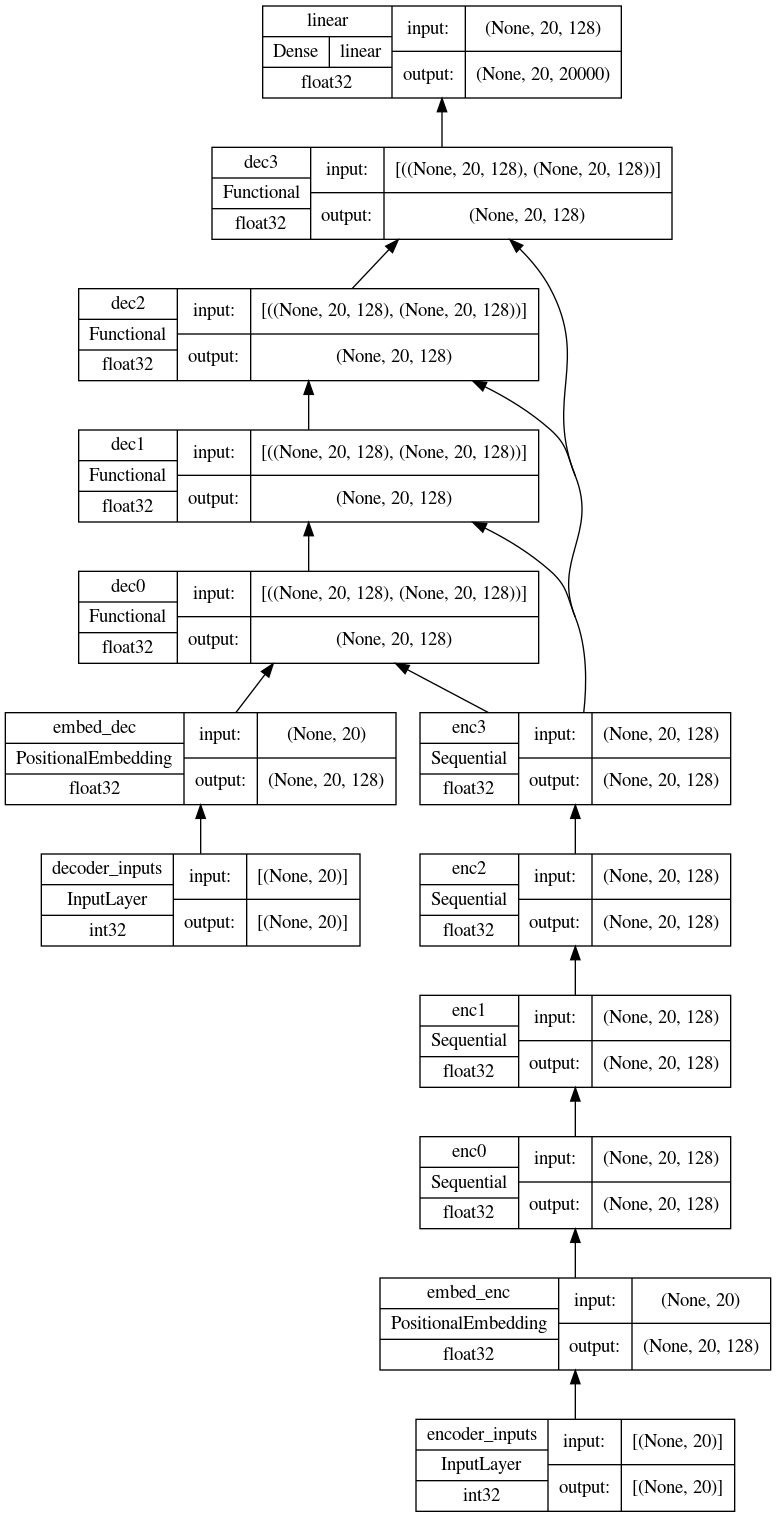

In [23]:
import tensorflow as tf

def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src,
                vocab_size_tgt, dropout=0.1, name="transformer"):
    embed_shape = (seq_len, key_dim)  # output shape of the positional embedding layer
    # set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32",
                                      name="decoder_inputs")
    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")
    encoders = [encoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape, key_dim=key_dim,
                        ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}",
                        num_heads=num_heads)
                for i in range(num_layers)]
    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")
    # build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)
    for layer in encoders:
        x1 = layer(x1)
    for layer in decoders:
        x2 = layer([x2, x1])
    output = final(x2)
    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass
    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model


seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
tf.keras.utils.plot_model(model, "transformer.png",
                          show_shapes=True, show_dtype=True, show_layer_names=True,
                          rankdir='BT', show_layer_activations=True)

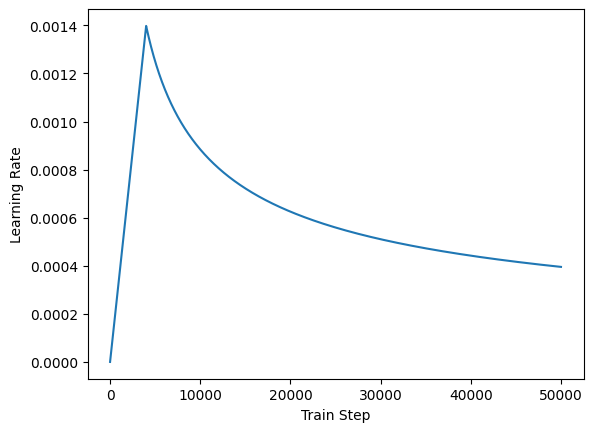

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    "Custom learning rate for Adam optimizer"
    def __init__(self, key_dim, warmup_steps=4000):
        super().__init__()
        self.key_dim = key_dim
        self.warmup_steps = warmup_steps
        self.d = tf.cast(self.key_dim, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        # to make save and load a model using custom layer possible0
        config = {
            "key_dim": self.key_dim,
            "warmup_steps": self.warmup_steps,
        }
        return config

key_dim = 128
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

plt.plot(lr(tf.range(50000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [25]:
def masked_loss(label, pred):
    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [26]:
vocab_size_en = 10000
vocab_size_fr = 20000
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 embed_enc (PositionalEmbedding  (None, 20, 128)     1280000     ['encoder_inputs[0][0]']         
 )                                                                                                
                                                                                                  
 enc0 (Sequential)              (None, 20, 128)      659712      ['embed_enc[0][0]']              
                                                                                                  
 enc1 (Sequential)              (None, 20, 128)      659712      ['enc0[0][0]']         

Epoch 1/20


2023-05-18 12:53:54.846928: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-18 12:53:56.492192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


1828/1828 [==============================] - 127s 63ms/step - loss: 2.1265 - masked_accuracy: 0.4262 - val_loss: 0.6233 - val_masked_accuracy: 0.8145
Epoch 2/20
1828/1828 [==============================] - 112s 61ms/step - loss: 0.4196 - masked_accuracy: 0.8852 - val_loss: 0.2992 - val_masked_accuracy: 0.9140
Epoch 3/20
1828/1828 [==============================] - 112s 61ms/step - loss: 0.2587 - masked_accuracy: 0.9317 - val_loss: 0.1893 - val_masked_accuracy: 0.9527
Epoch 4/20
1828/1828 [==============================] - 116s 63ms/step - loss: 0.2058 - masked_accuracy: 0.9490 - val_loss: 0.1506 - val_masked_accuracy: 0.9640
Epoch 5/20
1828/1828 [==============================] - 116s 64ms/step - loss: 0.1893 - masked_accuracy: 0.9549 - val_loss: 0.1381 - val_masked_accuracy: 0.9680
Epoch 6/20
1828/1828 [==============================] - 111s 61ms/step - loss: 0.1813 - masked_accuracy: 0.9580 - val_loss: 0.1356 - val_masked_accuracy: 0.9696
Epoch 7/20
1828/1828 [=======================

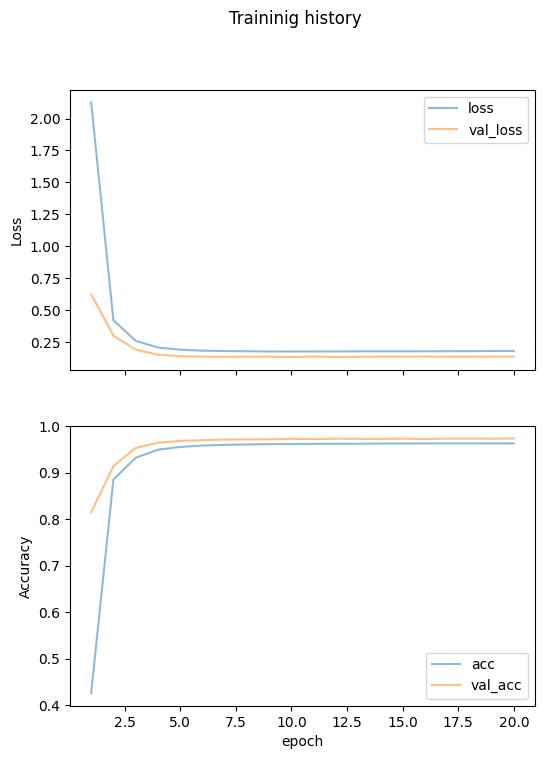

In [27]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Create and train the model
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim,
                    vocab_size_en, vocab_size_fr, dropout)
lr = CustomSchedule(key_dim)
optimizer = tf.keras.optimizers.Adam(lr, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
model.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

# Save the trained model
model.save("eng-fra-transformer.h5")

# Plot the loss and accuracy history
fig, axs = plt.subplots(2, figsize=(6, 8), sharex=True)
fig.suptitle('Traininig history')
x = list(range(1, epochs+1))
axs[0].plot(x, history.history["loss"], alpha=0.5, label="loss")
axs[0].plot(x, history.history["val_loss"], alpha=0.5, label="val_loss")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right")
axs[1].plot(x, history.history["masked_accuracy"], alpha=0.5, label="acc")
axs[1].plot(x, history.history["val_masked_accuracy"], alpha=0.5, label="val_acc")
axs[1].set_ylabel("Accuracy")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="lower right")
plt.show()

In [28]:
import pickle
import random

import numpy as np
import tensorflow as tf

# Load the trained model
custom_objects = {"PositionalEmbedding": PositionalEmbedding,
                  "CustomSchedule": CustomSchedule,
                  "masked_loss": masked_loss,
                  "masked_accuracy": masked_accuracy}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model("eng-fra-transformer.h5")

# training parameters used
seq_len = 20
vocab_size_en = 10000
vocab_size_fr = 20000

def translate(sentence):
    """Create the translated sentence"""
    enc_tokens = eng_vectorizer([sentence])
    lookup = list(fra_vectorizer.get_vocabulary())
    start_sentinel, end_sentinel = "[start]", "[end]"
    output_sentence = [start_sentinel]
    # generate the translated sentence word by word
    for i in range(seq_len):
        vector = fra_vectorizer([" ".join(output_sentence)])
        assert vector.shape == (1, seq_len+1)
        dec_tokens = vector[:, :-1]
        assert dec_tokens.shape == (1, seq_len)
        pred = model([enc_tokens, dec_tokens])
        assert pred.shape == (1, seq_len, vocab_size_fr)
        word = lookup[np.argmax(pred[0, i, :])]
        output_sentence.append(word)
        if word == end_sentinel:
            break
    return output_sentence

test_count = 20
for n in range(test_count):
    english_sentence, french_sentence = random.choice(test_pairs)
    translated = translate(english_sentence)
    print(f"Test {n}:")
    print(f"{english_sentence}")
    print(f"== {french_sentence}")
    print(f"-> {' '.join(translated)}")
    print()

Test 0:
someone is knocking at the door .
== [start] on frappe à la porte . [end]
-> [start] . . . . . . . . . . . [end]

Test 1:
i have a bad toothache .
== [start] j'ai un violent mal de dents . [end]
-> [start] . . . . . . . . . . . [end]

Test 2:
you should think of their religions .
== [start] vous devriez penser à leurs religions . [end]
-> [start] . . . . . . . . . . . [end]

Test 3:
make up your own mind .
== [start] décidez-vous par vous-même  !  [end]
-> [start] . . . . . . . . . . . [end]

Test 4:
he asked if i liked chinese food .
== [start] il m'a demandé si j'aimais la nourriture chinoise . [end]
-> [start] . . . . . . . . . . . [end]

Test 5:
if all else fails , reboot the system .
== [start] si toute autre mesure échoue , redémarrez le système . [end]
-> [start] . . . . . . . . . . . [end]

Test 6:
if we leave now , we should make it .
== [start] si nous partons maintenant , nous devrions y parvenir . [end]
-> [start] . . . . . . . . . . . [end]

Test 7:
you can't talk 

You did it!

Let’s go back and review what you did and what can be improved. You made a transformer model that takes an entire English sentence and a partial French sentence (up to the 
-th token) to predict the next (the 
-th) token.

In training, you observed that the accuracy is at 70% to 80% at the best. How can you improve it? Here are some ideas, but surely, not exhaustive:

- You used a simple tokenizer for your text input. Libraries such as NLTK can provide better tokenizers. Also, you didn’t use subword tokenization. It is less a problem for English but problematic for French. That’s why you have vastly larger vocabulary size in French in your model (e.g., l’air (the air) and d’air (of air) would become distinct tokens).
- You trained your own word embeddings with an embedding layer. There are pre-trained embeddings (such as GloVe) readily available, and they usually provide better quality embeddings. This may help your model to understand the context better.
- You designed the transformer with some parameters. You used 8 heads for multi-head attention, output vector dimension is 128, sentence length was limited to 20 tokens, drop out rate is 0.1, and so on. Tuning these parameters will surely impact the transformer one way or another. Similarly important are the training parameters such as number of epochs, learning rate schedule, and loss function.

You made it. Well done!

Take a moment and look back at how far you have come.

- You learned how to take a plaintext sentence, process it, and vectorize it
- You analyzed the building block of a transformer model according to the paper Attention Is All You Need, and implemented each building block using Keras
- You connected the building blocks into a complete transformer model, and train it
- Finally, you can witness the trained model to translate English sentences into French with high accuracy